In [ ]:
import geopandas as gpd
from google.colab import drive
drive.mount('/content/drive')

shp_path =  '/content/drive/MyDrive/Tesis/Datos/v_camineria_nacional.shp'
roads = gpd.read_file(shp_path)

print(roads.columns)
print(roads.crs, roads.head())

Mounted at /content/drive
Index(['gid', 'codigo', 'numero', 'nombre', 'depto', 'jurisdicci', 'categoria',
       'sentido', 'carriles', 'calzada', 'fuente', 'observacio', 'nat_juridi',
       'geometry'],
      dtype='object')
EPSG:4326        gid     codigo  numero                        nombre depto  \
0  3344250  UY0110000    11.0         José Batlle y Ordoñez  UYCA   
1   349731  UY0110000    11.0         José Batlle y Ordoñez  UYCA   
2   292738  UY0270000    27.0                   Mario Heber  UYRV   
3   305834  UY0050000     5.0  Brig. Gral. Fructuoso Rivera  UYMO   
4  3343102   UYTA0284     NaN                          None  UYTA   

    jurisdicci                categoria  \
0     NACIONAL   CORREDOR INTERNACIONAL   
1     NACIONAL   CORREDOR INTERNACIONAL   
2     NACIONAL          RUTA SECUNDARIA   
3     NACIONAL   CORREDOR INTERNACIONAL   
4  SIN DEFINIR  CAMINERÍA DEPARTAMENTAL   

                                             sentido carriles        calzada  \
0  EL SEN

In [ ]:
# Filter the GeoDataFrame for route 8
route_5 = roads[roads['numero'] == 5]

# Display the geometry (coordinates) of route 8
print("Coordinates of Route 5:")
display(route_5.geometry)

Coordinates of Route 5:


,geometry
3,"LINESTRING (-56.27475 -34.78458, -56.27479 -34..."
6,"LINESTRING (-56.26215 -34.59394, -56.26218 -34..."
10,"LINESTRING (-56.46557 -33.05608, -56.46508 -33..."
11,"LINESTRING (-56.25983 -34.61428, -56.26012 -34..."
13,"LINESTRING (-56.24243 -34.6461, -56.2426 -34.6..."
...,...
39478,"LINESTRING (-56.19838 -34.09464, -56.19836 -34..."
39479,"LINESTRING (-56.19743 -34.09574, -56.1975 -34...."
39484,"LINESTRING (-56.19717 -34.09614, -56.19724 -34..."
39485,"LINESTRING (-56.19773 -34.09548, -56.19761 -34..."


In [ ]:
""" Funcion para llamar la API de maps y descargar la imagen satelital
import requests, time, os

API_KEY = ""

session = requests.Session()

def test_static_maps_key(lat, lon, zoom=20, size=(640, 640), scale=1, maptype="satellite",
                         api_key=API_KEY, retries=3, backoff=1.5):

    w, h = size
    url = "https://maps.googleapis.com/maps/api/staticmap"
    params = {
        "center": f"{lat},{lon}",
        "zoom": str(zoom),
        "size": f"{w}x{h}",
        "scale": str(scale),
        "maptype": maptype,
        "key": api_key,
    }
    last = None
    for attempt in range(1, retries+1):
        r = session.get(url, params=params, timeout=30)
        last = r
        if r.status_code == 200 and r.headers.get("content-type","").startswith("image/"):
            return r.content
        time.sleep(backoff ** attempt)
    raise RuntimeError(f"HTTP {last.status_code}: {last.text[:200]}")

In [ ]:
""" descargar las imagenes satelitales
# --- Parámetros ---
STEP_METERS = 50  # 40–60 m da buen solapamiento a zoom 20
ZOOM = 20
SIZE = (640, 640)
SCALE = 1
MAPTYPE = "satellite"
OUTPUT_DIR = "/content/drive/My Drive/Tesis/Datos/Imagenes_Satelitales_Ruta_5"

import os, time, random, numpy as np, geopandas as gpd, pandas as pd
from shapely.geometry import LineString, MultiLineString, Point
from shapely.ops import unary_union
from pyproj import Transformer

os.makedirs(OUTPUT_DIR, exist_ok=True)

# 1) Asegurar WGS84 (lat/lon)
route_5 = route_5.to_crs(4326)

# 2) Unir toda la geometría de la Ruta 5
merged = unary_union(route_5.geometry)

# 3) Pasar a metros (EPSG:3857), muestrear cada STEP_METERS, volver a 4326
g3857 = gpd.GeoSeries([merged], crs=4326).to_crs(3857).iloc[0]

def iter_lines(g):
    if isinstance(g, LineString):
        yield g
    elif isinstance(g, MultiLineString):
        for gg in g.geoms:
            if isinstance(gg, (LineString, MultiLineString)):
                yield from iter_lines(gg)

# Muestreo ordenado con deduplicación estable
pts_3857 = []
for line in iter_lines(g3857):
    L = float(line.length)
    dists = np.arange(0, max(L, 1.0), STEP_METERS, dtype=float).tolist()
    if not dists or dists[-1] < L:
        dists.append(L)
    for d in dists:
        pts_3857.append(line.interpolate(d))

to4326 = Transformer.from_crs(3857, 4326, always_xy=True)

coords = []
seen = set()
for p in pts_3857:
    lat = to4326.transform(p.x, p.y)[1]
    lon = to4326.transform(p.x, p.y)[0]
    key = (round(lat, 6), round(lon, 6))
    if key not in seen:
        seen.add(key)
        coords.append((lat, lon))

print(f"Puntos a descargar: {len(coords)} (paso ~{STEP_METERS} m)")

# 4) Descarga con tu función test_static_maps_key
def outname(i):
    return os.path.join(OUTPUT_DIR, f"ruta5_pt_{i:05d}_z{ZOOM}.png")

# =============================
# >>> NUEVO: índice (DataFrame)
# =============================
rows = []
for i, (lat, lon) in enumerate(coords, start=1):
    path = outname(i)
    rows.append({
        "idx": i,
        "filename": f"ruta5_pt_{i:05d}_z{ZOOM}.png",
        "path": path,
        "lat": lat,
        "lon": lon,
        "exists_before": os.path.exists(path),
        "downloaded": False,   # se actualizará durante/tras la descarga
        "error": ""            # se completa si falla
    })

df = pd.DataFrame(rows).set_index("idx").sort_index()

remaining = [(i, lat, lon) for i, (lat, lon) in enumerate(coords, start=1)
             if not df.loc[i, "exists_before"]]

print(f"Total puntos: {len(coords)} | Faltan: {len(remaining)}")

errores = []
for i, lat, lon in remaining:
    try:
        img = test_static_maps_key(
            lat, lon,
            zoom=ZOOM, size=SIZE, scale=SCALE, maptype=MAPTYPE
        )
        with open(outname(i), "wb") as f:
            f.write(img)
        df.loc[i, "downloaded"] = True
        if i % 100 == 0:
            print(f"✅ Guardadas hasta el índice {i}")
    except Exception as e:
        msg = str(e)[:200]
        errores.append((i, lat, lon, msg))
        df.loc[i, "error"] = msg
        print(f"❌ {i} ({lat:.6f},{lon:.6f}) -> {msg}")
    # ~1–2 req/s con jitter para evitar 429
    time.sleep(0.25 + random.random() * 0.25)

# Marcar como descargado todo lo que efectivamente exista (por si algo preexistía)
df["downloaded"] = df["downloaded"] | (~df["exists_before"] & df["path"].apply(os.path.exists))

print("Hecho. Carpeta:", OUTPUT_DIR)
if errores:
    print(f"Quedaron {len(errores)} errores (podés reintentar solo esos).")

# =============================
# >>> NUEVO: guardar índice CSV + GeoJSON
# =============================
index_csv    = os.path.join(OUTPUT_DIR, f"ruta5_index_z{ZOOM}.csv")
index_geojson= os.path.join(OUTPUT_DIR, f"ruta5_index_z{ZOOM}.geojson")

# GeoDataFrame con puntos (WGS84)
gdf = gpd.GeoDataFrame(
    df.reset_index(),
    geometry=gpd.points_from_xy(df["lon"], df["lat"]),
    crs="EPSG:4326"
)

df.to_csv(index_csv, index=False)
# GeoJSON (compatible con QGIS/Kepler/Leaflet)
gdf.to_file(index_geojson, driver="GeoJSON")

print(f"🗂️ Índice CSV guardado en: {index_csv}")
print(f"🗺️ GeoJSON guardado en:    {index_geojson}")


In [ ]:
!pip install roboflow

In [ ]:
# -*- coding: utf-8 -*-
# Combinar modelo de Paradas + modelo de Ruta para filtrar falsos positivos "en/encima de la ruta"
# Requiere: roboflow, shapely, pillow
# Si falta algo en Colab: !pip install shapely pillow roboflow --quiet
"""
import os, glob, shutil
from google.colab import drive
import uuid
from roboflow import Roboflow
from PIL import Image, ImageDraw, ImageFont
from shapely.geometry import Polygon, Point, box
from shapely.ops import unary_union

# =========================
# 0) Parámetros ajustables
# =========================
CONF_PARADAS_MIN   = 55   # % mínimo para que el modelo de paradas reporte (igual que venías usando)
CONF_SEGURA_UMBRAL =  75 # % mínimo para clasificar como "segura" (entre las válidas)
ROUTE_BUFFER_PX    = 10   # px de tolerancia alrededor de la ruta para filtrar paradas "encima" de la ruta
OVERLAP_PCT        = 30   # NMS overlap (Roboflow)

# =========================
# 1) Montar Drive y carpetas
# =========================

drive.mount('/content/drive')
base_dir      = '/content/drive/MyDrive/Tesis/Datos/Imagenes_Satelitales_Ruta_5'
seguras_dir   = os.path.join(base_dir, "paradas_seguras")
noseguras_dir = os.path.join(base_dir, "paradas_no_seguras")
os.makedirs(seguras_dir, exist_ok=True)
os.makedirs(noseguras_dir, exist_ok=True)

# =========================
# 2) Cargar modelos Roboflow
# =========================
rf = Roboflow(api_key="ROBOFLOW_API_KEY")  # o usa

# Modelo de paradas
project_paradas = rf.project("tesis-um-n0pxr")
model_paradas   = project_paradas.version(3).model

# Modelo de ruta (detección o segmentación)
project_ruta = rf.project("identificador-de-rutas-qnmf6")
model_ruta   = project_ruta.version(2).model"""


In [ ]:
'''#Acá validamos el funcionamiento con un par de imágenes, modifiicamos los parámetros, y ahora vamos a corregir el orden de la función, para primero indenficificar las paradas y luego segmentar la ruta

#import uuid

IMG_PATH = '/content/drive/MyDrive/Tesis/Datos/Ruta8/ruta8_pt_00298_z20.png'

fname = os.path.basename(IMG_PATH)
print(f"\n🔍 Procesando {fname}")

# Preparamos versión RGB temporal para robustez con el SDK
rgb_path = _prep_rgb_for_rf(IMG_PATH)

# --- modelo de paradas
res_paradas = model_paradas.predict(rgb_path, confidence=CONF_PARADAS_MIN, overlap=OVERLAP_PCT).json()
preds_paradas = res_paradas.get('predictions', [])
print(f"Paradas detectadas: {len(preds_paradas)}")

if not preds_paradas:
    print("⚠️ No se detectaron paradas.")
    try:
        res_ruta = model_ruta.predict(rgb_path, confidence=30, overlap=OVERLAP_PCT).json()
    except TypeError:
        res_ruta = model_ruta.predict(rgb_path, confidence=30).json()

    preds_ruta = res_ruta.get('predictions', [])
    ruta_union = union_polygons(preds_ruta, buffer_px=ROUTE_BUFFER_PX)

    # --- filtrado
    paradas_validas, paradas_filtradas = [], []
    for p in preds_paradas:
        pt = Point(p['x'], p['y'])
        inside = (ruta_union is not None) and ruta_union.contains(pt)
        (paradas_filtradas if inside else paradas_validas).append(p)
else:
    # --- modelo de ruta (detección vs segmentación: algunos no aceptan 'overlap')
    try:
        res_ruta = model_ruta.predict(rgb_path, confidence=30, overlap=OVERLAP_PCT).json()
    except TypeError:
        res_ruta = model_ruta.predict(rgb_path, confidence=30).json()

    preds_ruta = res_ruta.get('predictions', [])
    ruta_union = union_polygons(preds_ruta, buffer_px=ROUTE_BUFFER_PX)

    # --- filtrado
    paradas_validas, paradas_filtradas = [], []
    for p in preds_paradas:
        pt = Point(p['x'], p['y'])
        inside = (ruta_union is not None) and ruta_union.contains(pt)
        (paradas_filtradas if inside else paradas_validas).append(p)

    # --- resumen
    print(f"Paradas válidas fuera de la ruta: {len(paradas_validas)}")
    print(f"Paradas filtradas (sobre ruta):   {len(paradas_filtradas)}")

    print("\n📍 Detalle de paradas válidas:")
    for p in paradas_validas:
        print(f"  - {p['class']} | conf={p['confidence']*100:.1f}% | x={p['x']:.1f}, y={p['y']:.1f}")

    print("\n🚫 Paradas filtradas por ruta:")
    for p in paradas_filtradas:
        print(f"  - {p['class']} | conf={p['confidence']*100:.1f}% | x={p['x']:.1f}, y={p['y']:.1f}")

    # --- evaluación
    if paradas_validas:
        max_conf = max(p['confidence'] for p in paradas_validas)*100
        if max_conf > CONF_SEGURA_UMBRAL:
            print(f"\n✅ Imagen clasificada como SEGURA (max_conf={max_conf:.1f}%)")
        else:
            print(f"\n⚠️ Imagen clasificada como NO SEGURA (confianza válida={max_conf:.1f}%)")
    else:
        print("\n⚠️ Imagen clasificada como NO SEGURA (todas las paradas fueron filtradas por ruta)")'''

In [ ]:
'''# --- BLOQUE OPCIONAL DE VISUALIZACIÓN ---
# Muestra inline la imagen con las detecciones y segmentaciones superpuestas

import matplotlib.pyplot as plt
from PIL import ImageDraw

def overlay_polygon(image, poly, outline=(255,255,255), fill_alpha=50):
    """Dibuja la ruta como región translúcida."""
    if poly is None or poly.is_empty:
        return image
    base = image.convert("RGBA")
    overlay = Image.new("RGBA", base.size, (0,0,0,0))
    draw = ImageDraw.Draw(overlay, "RGBA")

    def _draw_single(p):
        ext = [(int(x), int(y)) for x, y in p.exterior.coords]
        draw.polygon(ext, fill=(255,255,255,fill_alpha), outline=outline+(255,))
        for hole in p.interiors:
            pts = [(int(x), int(y)) for x, y in hole.coords]
            draw.polygon(pts, fill=(0,0,0,0), outline=outline+(255,))

    if poly.geom_type == "Polygon":
        _draw_single(poly)
    elif poly.geom_type == "MultiPolygon":
        for g in poly.geoms:
            _draw_single(g)

    return Image.alpha_composite(base, overlay).convert("RGB")

def draw_bbox(draw, pred, outline=(0,255,0), width=3, label=None):
    """Dibuja caja para detección."""
    x, y = pred['x'], pred['y']
    w, h = pred['width'], pred['height']
    x0, y0 = int(x - w/2), int(y - h/2)
    x1, y1 = int(x + w/2), int(y + h/2)
    draw.rectangle([x0, y0, x1, y1], outline=outline, width=width)
    if label:
        draw.text((x0+3, y0+3), label, fill=outline)

# --- construir imagen anotada ---
im = Image.open(IMG_PATH).convert("RGB")
im = overlay_polygon(im, ruta_union, outline=(255,255,255), fill_alpha=40)
draw = ImageDraw.Draw(im)

for p in paradas_validas:
    conf_pct = round(p['confidence']*100, 1)
    draw_bbox(draw, p, outline=(0,200,0), width=3, label=f"{p['class']} {conf_pct}%")

for p in paradas_filtradas:
    conf_pct = round(p['confidence']*100, 1)
    draw_bbox(draw, p, outline=(220,0,0), width=3, label=f"FILTRADA {conf_pct}%")

# --- mostrar ---
plt.figure(figsize=(8,8))
plt.imshow(im)
plt.axis("off")
plt.title("Verde: válidas  |  Rojo: filtradas  |  Blanco: ruta")
plt.show()
'''

In [ ]:


# =========================
# 3) Utilitarios de geometría
# =========================
def pred_to_polygon(pred, buffer_px=0):
    """
    Convierte una predicción de Roboflow a un polígono de shapely.
    - Si es segmentación: usa pred['points'].
    - Si es detección: arma un rectángulo desde x,y,width,height.
    Aplica buffer (px) si se desea ensanchar.
    """
    if 'points' in pred and pred['points']:
        # Polígono (segmentación)
        pts = [(p['x'], p['y']) for p in pred['points']]
        poly = Polygon(pts)
    else:
        # Bounding box (detección)
        x, y = pred['x'], pred['y']
        w, h = pred['width'], pred['height']
        poly = box(x - w/2, y - h/2, x + w/2, y + h/2)
    if buffer_px and buffer_px > 0:
        # buffer en pixeles (en coords de imagen ya son px)
        poly = poly.buffer(buffer_px)
    return poly

def union_polygons(preds, buffer_px=0):
    """Crea la unión geométrica de las regiones detectadas/segmentadas de la ruta."""
    if not preds:
        return None
    polys = []
    for pr in preds:
        try:
            polys.append(pred_to_polygon(pr, buffer_px=buffer_px))
        except Exception:
            # Si una máscara viene malformada, la saltamos
            continue
    if not polys:
        return None
    return unary_union(polys)

def draw_bbox(draw, pred, outline=(0,255,0), width=3, label=None):
    """Dibuja una caja del pred (x,y,w,h) con un posible label."""
    x, y = pred['x'], pred['y']
    w, h = pred['width'], pred['height']
    x0, y0 = int(x - w/2), int(y - h/2)
    x1, y1 = int(x + w/2), int(y + h/2)
    draw.rectangle([x0, y0, x1, y1], outline=outline, width=width)
    if label:
        # Texto sobre el bbox
        try:
            # Colab suele no tener fuentes TTF por defecto; usamos la default.
            draw.text((x0+4, y0+4), label, fill=outline)
        except Exception:
            pass

def overlay_polygon(image, poly, outline=(255,255,255), fill_alpha=50, width=2):
    """
    Dibuja una región poligonal (o multipolígono) sobre la imagen con relleno semitransparente.
    """
    if poly is None or poly.is_empty:
        return image
    # Creamos overlay con alpha
    overlay = image.copy()
    overlay = overlay.convert("RGBA")
    tmp = Image.new("RGBA", overlay.size, (0,0,0,0))
    draw_tmp = ImageDraw.Draw(tmp, "RGBA")

    def _draw_single(p):
        try:
            exterior = [(int(x), int(y)) for x, y in p.exterior.coords]
            draw_tmp.polygon(exterior, fill=(255,255,255,fill_alpha), outline=outline+(255,))
            # holes
            for hole in p.interiors:
                hole_pts = [(int(x), int(y)) for x, y in hole.coords]
                draw_tmp.polygon(hole_pts, fill=(0,0,0,0), outline=outline+(255,))
        except Exception:
            pass

    if poly.geom_type == "Polygon":
        _draw_single(poly)
    elif poly.geom_type == "MultiPolygon":
        for p in poly.geoms:
            _draw_single(p)

    # Unir overlay
    out = Image.alpha_composite(overlay, tmp)
    return out.convert("RGB")


In [ ]:
# =========================
# 4) Procesamiento por imagen
# =========================
imgs = glob.glob(os.path.join(base_dir, '*.png'))

# Create a temporary directory for processing
temp_dir = "/content/temp_images"
os.makedirs(temp_dir, exist_ok=True)

for img_path in imgs:
    fname = os.path.basename(img_path)

    # Convert image to RGB and save temporarily
    try:
        im = Image.open(img_path).convert("RGB")
        temp_img_path = os.path.join(temp_dir, fname)
        im.save(temp_img_path)
    except Exception as e:
        print(f"Error converting image {fname}: {e}")
        continue


    # --- 4.1) Paradas
    result_paradas = model_paradas.predict(
        temp_img_path, confidence=CONF_PARADAS_MIN, overlap=OVERLAP_PCT
    ).json()
    preds_paradas = result_paradas.get('predictions', [])

    # Si no hay paradas, guardamos la original anotada mínimamente en no seguras
    if not preds_paradas:
        # Save the original RGB converted image
        #im.save(os.path.join(noseguras_dir, fname))
        print(f"{fname}: ⚠️ no segura (sin paradas)")
        # Clean up temporary file
        os.remove(temp_img_path)
        continue

    # --- 4.2) Ruta (detección/segmentación)
    result_ruta = model_ruta.predict(
        temp_img_path, confidence=30
    ).json()
    preds_ruta = result_ruta.get('predictions', [])

    # Unión de polígonos de la ruta (buffer configurable)
    ruta_union = union_polygons(preds_ruta, buffer_px=ROUTE_BUFFER_PX)

    # --- 4.3) Filtrado de paradas: dentro de la ruta => falso positivo
    paradas_validas = []
    paradas_filtradas = []
    for p in preds_paradas:
        pt = Point(p['x'], p['y'])
        inside_route = (ruta_union is not None) and ruta_union.contains(pt)
        if inside_route:
            paradas_filtradas.append(p)
        else:
            paradas_validas.append(p)

    # --- 4.4) Anotación manual (verde=válida, rojo=filtrada), ruta en blanco translúcido
    im = Image.open(temp_img_path).convert("RGB") # Open the converted RGB image
    im = overlay_polygon(im, ruta_union, outline=(255,255,255), fill_alpha=40, width=2)
    draw = ImageDraw.Draw(im)

    # Dibujar paradas válidas (verde) y filtradas (rojo)
    for p in paradas_validas:
        conf_pct = round(p['confidence']*100, 1)
        label = f"{p['class']} {conf_pct}%"
        draw_bbox(draw, p, outline=(0,200,0), width=3, label=label)

    for p in paradas_filtradas:
        conf_pct = round(p['confidence']*100, 1)
        label = f"FILTRADA {conf_pct}%"
        draw_bbox(draw, p, outline=(220,0,0), width=3, label=label)

    # Footer con conteos
    txt = f"Válidas: {len(paradas_validas)} | Filtradas por ruta: {len(paradas_filtradas)}"
    try:
        draw.text((10, 10), txt, fill=(255,255,0))
    except Exception:
        pass

    # --- 4.5) Regla de clasificación: usa SOLO las válidas
    if paradas_validas:
        max_conf_valida = max(p['confidence'] for p in paradas_validas) * 100.0
        if max_conf_valida > CONF_SEGURA_UMBRAL:
            im.save(os.path.join(seguras_dir, fname))
            print(f"{fname}: ✅ segura | {txt} | max válida={max_conf_valida:.1f}%")
        else:
            im.save(os.path.join(noseguras_dir, fname))
            print(f"{fname}: ⚠️ no segura (baja confianza válida) | {txt} | max válida={max_conf_valida:.1f}%")
    else:
        # No quedó ninguna válida después del filtro de ruta
        im.save(os.path.join(noseguras_dir, fname))
        print(f"{fname}: ⚠️ no segura (todas filtradas por ruta) | {txt}")

    # Clean up temporary file
    os.remove(temp_img_path)

# Clean up temporary directory
os.rmdir(temp_dir)

In [ ]:
import geopandas as gpd
import folium

# --- 3) Definir la ruta al archivo KML ---
kml_path = '/content/drive/MyDrive/Tesis/Datos/Oct_5,_2025_14_03_32.kml'

# --- 4) Leer el archivo KML ---
# GeoPandas usa el driver "KML" de GDAL (ya viene en Colab)
gdf = gpd.read_file(kml_path, driver='KML')

# --- 5) Mostrar info básica ---
print("Número de puntos:", len(gdf))
print(gdf.head())

# --- 6) Crear un mapa centrado en el promedio de los puntos ---
center = [gdf.geometry.y.mean(), gdf.geometry.x.mean()]
m = folium.Map(location=center, zoom_start=8, tiles='OpenStreetMap')

# --- 7) Agregar las paradas al mapa ---
for _, row in gdf.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=str(row.get('Name', 'Parada sin nombre'))
    ).add_to(m)

# --- 8) Mostrar el mapa ---
m


Número de puntos: 162
               Name                                        Description  \
0  Current location     Speed: 0 mph Elevation: 757 ft Accuracy: 12 ft   
1   Stop for ~3 min  Elevation: 227 m Time from start: 00:03:34 Dis...   
2         1 derecha  Speed: 22.57 mph Elevation: 829 ft Time from s...   
3       2 izquierda  Speed: 25.39 mph Elevation: 813 ft Time from s...   
4         3 derecha  Speed: 80 mph Elevation: 808 ft Time from star...   

                               geometry  
0    POINT Z (-55.528 -30.90962 230.62)  
1  POINT Z (-55.52801 -30.90962 227.44)  
2  POINT Z (-55.54903 -30.93862 252.58)  
3  POINT Z (-55.58999 -31.00411 248.84)  
4   POINT Z (-55.6024 -31.04544 243.23)  


In [ ]:
# --- Setup básico ---
from google.colab import drive
drive.mount('/content/drive')

import os, shutil, math
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from sklearn.cluster import DBSCAN

# --- Parámetros / Paths ---
BASE_DIR = "/content/drive/MyDrive/Tesis/Datos/Imagenes_Satelitales_Ruta_5"
SAFE_DIR = f"{BASE_DIR}/paradas_seguras"                          # carpeta con imágenes "seguras"
CSV_PATH = f"{BASE_DIR}/ruta5_index_z20.csv"                      # tu CSV con filename/lat/lon
OUTPUT_DIR = f"{BASE_DIR}/paradas_seguras_outputs"                # carpeta para salidas tabulares/geojson
DEDUP_IMG_DIR = f"{BASE_DIR}/paradas_seguras_dedup"               # carpeta con imágenes deduplicadas
EPS_METERS = 100.0                                                # umbral de distancia en metros para considerar duplicado
EPSG_URUGUAY_UTM21S = 32721                                       # proyección métrica

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(DEDUP_IMG_DIR, exist_ok=True)

# --- 1) Leer CSV con index de imágenes (filename, lat, lon) ---
df = pd.read_csv(CSV_PATH)

# sanity check columnas mínimas
req_cols = {"filename","lat","lon"}
missing = req_cols - set(df.columns.str.lower())
if missing:
    raise ValueError(f"Faltan columnas en el CSV: {missing}. Columnas encontradas: {df.columns.tolist()}")

# Normalizar nombres de columnas por las dudas
df = df.rename(columns={"Latitude":"lat","Lat":"lat","Lon":"lon","Longitude":"lon","FileName":"filename","file_name":"filename"})

# --- 2) Listar solamente las imágenes que están en paradas_seguras ---
safe_files = [f for f in os.listdir(SAFE_DIR) ]

safe_df = df[df["filename"].isin(safe_files)].copy()

print(f"Imágenes seguras en carpeta: {len(safe_files)}")
print(f"Coincidencias filename en CSV: {len(safe_df)}")
if len(safe_df) == 0:
    raise RuntimeError("No se encontraron coincidencias entre filenames en paradas_seguras y el CSV. Revisar nombres/paths.")

# --- 3) GeoDataFrame WGS84 y proyectar a metros (EPSG:32721) ---
gdf_wgs = gpd.GeoDataFrame(
    safe_df,
    geometry=[Point(xy) for xy in zip(safe_df["lon"].values, safe_df["lat"].values)],
    crs=4326
)
gdf_m = gdf_wgs.to_crs(EPSG_URUGUAY_UTM21S)

# --- 4) DBSCAN en metros ---
coords_m = np.column_stack([gdf_m.geometry.x.values, gdf_m.geometry.y.values])
labels = DBSCAN(eps=EPS_METERS, min_samples=1, metric="euclidean").fit(coords_m).labels_
gdf_m["cluster_id"] = labels
gdf_m["cluster_size"] = gdf_m.groupby("cluster_id")["cluster_id"].transform("size")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Imágenes seguras en carpeta: 286
Coincidencias filename en CSV: 286


In [ ]:
# --- 5) Seleccionar un elemento representativo por cluster
representatives = gdf_m.loc[gdf_m.groupby("cluster_id").apply(
    lambda x: x.geometry.distance(x.geometry.unary_union.centroid).idxmin()
)]

# Display the representative element for each cluster
print("\nRepresentantes de cada cluster:")
display(representatives)

# Convert representatives back to WGS84 for plotting
representatives_wgs = representatives.to_crs(4326)

# --- 6) Opcional: Guardar CSV y GeoJSON de los representantes ---
representatives_csv     = os.path.join(OUTPUT_DIR, f"ruta5_paradas_representantes.csv")
representatives_geojson = os.path.join(OUTPUT_DIR, f"ruta5_paradas_representantes.geojson")

representatives_wgs.to_csv(representatives_csv, index=False)
representatives_wgs.to_file(representatives_geojson, driver="GeoJSON")

print(f"\n🗂️ Representantes CSV guardado en: {representatives_csv}")
print(f"🗺️ Representantes GeoJSON guardado en:    {representatives_geojson}")

# --- 7) Opcional: Copiar imágenes representativas a una nueva carpeta ---
for index, row in representatives_wgs.iterrows():
    src_path = row["path"]
    dest_path = os.path.join(DEDUP_IMG_DIR, row["filename"])
    if os.path.exists(src_path):
        shutil.copy(src_path, dest_path)
    else:
        print(f"Advertencia: La imagen {src_path} no fue encontrada.")

print(f"\n🖼️ Imágenes representativas copiadas a: {DEDUP_IMG_DIR}")

/tmp/ipython-input-2530945813.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  lambda x: x.geometry.distance(x.geometry.unary_union.centroid).idxmin()
/tmp/ipython-input-2530945813.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  lambda x: x.geometry.distance(x.geometry.unary_union.centroid).idxmin()
/tmp/ipython-input-2530945813.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  lambda x: x.geometry.distance(x.geometry.unary_union.centroid).idxmin()
/tmp/ipython-input-2530945813.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  lambda x: x.geometry.distance(x.geometry.unary_union.centroid).idxmin()
/tmp/ipython-input-2530945813.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  lambda x: x.geome


Representantes de cada cluster:


,filename,path,lat,lon,exists_before,downloaded,error,geometry,cluster_id,cluster_size
2783,ruta5_pt_02784_z20.png,/content/drive/My Drive/Tesis/Datos/Imagenes_S...,-32.180577,-56.141555,False,True,NaN,POINT (580926.698 6439225.522),0,1
2824,ruta5_pt_02825_z20.png,/content/drive/My Drive/Tesis/Datos/Imagenes_S...,-33.832151,-56.299313,False,True,NaN,POINT (564834.496 6256233.821),1,1
2844,ruta5_pt_02845_z20.png,/content/drive/My Drive/Tesis/Datos/Imagenes_S...,-34.161474,-56.179938,False,True,NaN,POINT (575588.32 6219636.055),2,1
2862,ruta5_pt_02863_z20.png,/content/drive/My Drive/Tesis/Datos/Imagenes_S...,-33.922442,-56.251055,False,True,NaN,POINT (569226.946 6246190.964),3,1
2864,ruta5_pt_02865_z20.png,/content/drive/My Drive/Tesis/Datos/Imagenes_S...,-33.993393,-56.240890,False,True,NaN,POINT (570108.327 6238316.931),4,1
...,...,...,...,...,...,...,...,...,...,...
13418,ruta5_pt_13419_z20.png,/content/drive/My Drive/Tesis/Datos/Imagenes_S...,-33.127241,-56.460546,False,True,NaN,POINT (550321.401 6334477.492),162,2
13473,ruta5_pt_13474_z20.png,/content/drive/My Drive/Tesis/Datos/Imagenes_S...,-33.106562,-56.459721,False,True,NaN,POINT (550410.169 6336769.674),163,1
13502,ruta5_pt_13503_z20.png,/content/drive/My Drive/Tesis/Datos/Imagenes_S...,-34.388350,-56.254090,False,True,NaN,POINT (568568.855 6194531.092),164,1
13701,ruta5_pt_13702_z20.png,/content/drive/My Drive/Tesis/Datos/Imagenes_S...,-34.773589,-56.270117,False,True,NaN,POINT (566786.573 6151821.99),165,1



🗂️ Representantes CSV guardado en: /content/drive/MyDrive/Tesis/Datos/Imagenes_Satelitales_Ruta_5/paradas_seguras_outputs/ruta5_paradas_representantes.csv
🗺️ Representantes GeoJSON guardado en:    /content/drive/MyDrive/Tesis/Datos/Imagenes_Satelitales_Ruta_5/paradas_seguras_outputs/ruta5_paradas_representantes.geojson


KeyboardInterrupt: 

In [ ]:
import folium

# Create a map centered on the average location of all points
center_lat = gdf.geometry.y.mean()
center_lon = gdf.geometry.x.mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=8)

# Add all original points as blue circles
for idx, row in gdf.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=3,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        popup=f"Original Point {idx}"
    ).add_to(m)

# Add representative points as red circles
for idx, row in representatives_wgs.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,  # Slightly larger radius for representatives
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.1,
        popup=f"Representative Point {idx}"
    ).add_to(m)

# Display the map
m

Representative Point 8748 - Cartel
Representative Point 12390 - Cartel haciendo sombra





cruzar las paradas originales con las de nuestro modelo.

arrancar la optimización de paradas para esta ruta


Las imagenes satelitales son anteriores a las ultimas obras de las rutas por tanto estan desactualizadas,
lo cual lleva a incoherencias entre informacion recabada insitu y paradas detectadas por satelite.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


roads_valid = roads[roads.geometry.is_valid].reset_index(drop=True)

# Paleta de 4 azules distintos
azules = sns.color_palette("Blues", 4).as_hex()

def graficar_paradas(gdf, titulo = None):
  fig, ax = plt.subplots(figsize=(8,8))

  roads_valid[roads_valid["categoria"]=="CORREDOR INTERNACIONAL"].plot(
      ax=ax, color=azules[3], linewidth=2, label="Corredor Internacional"
  )
  roads_valid[roads_valid["categoria"]=="RUTA PRIMARIA"].plot(
      ax=ax, color=azules[2], linewidth=1.8, label="Ruta Primaria"
  )
  roads_valid[roads_valid["categoria"]=="RUTA SECUNDARIA"].plot(
      ax=ax, color=azules[1], linewidth=1.5, label="Ruta Secundaria"
  )
  roads_valid[roads_valid["categoria"]=="RUTA TERCIARIA"].plot(
      ax=ax, color=azules[0], linewidth=1.2, label="Ruta Terciaria"
  )


  # Plot the bus stops
  gdf.plot(ax=ax, color='red', markersize=20, label='Paradas Ruta 5')

  ax.set_title(titulo)
  ax.set_xlabel("Lon")
  ax.set_ylabel("Lat")
  plt.legend()
  plt.show()


In [ ]:
len(representatives_wgs)

167

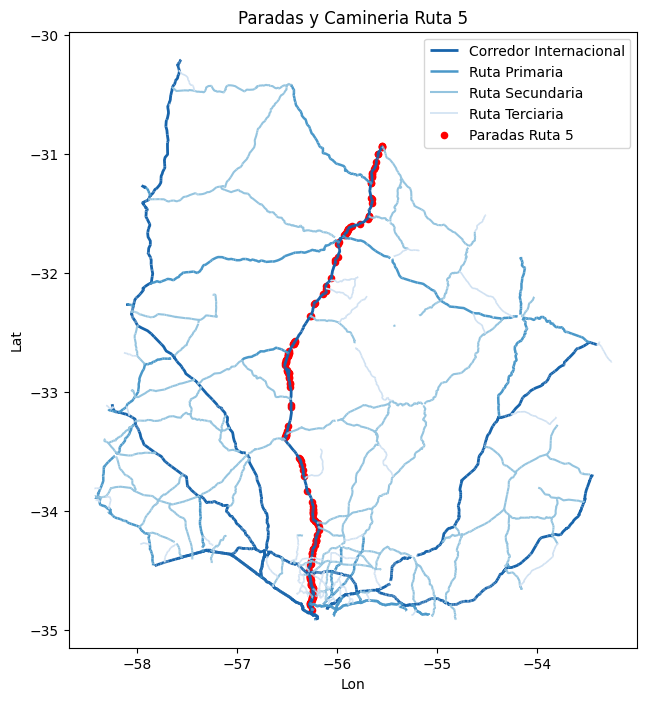

In [ ]:
graficar_paradas(representatives_wgs, titulo = "Paradas y Camineria Ruta 5")